# SaveとLoad

In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

## Early Stoping

- 以前作成した学習ループを関数化し、early stoppingを追加する
    - early stopping引数を追加し、early stopping数のepoch数検証データの損失が現象しなかったら学習を止めるようにする
    - early_stopping引数にNoneを指定すると、early_stoppingしないようにする

In [2]:
# ================MLP自作クラス=================
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        # z1 = self.l1(x)
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x

In [3]:
# =============自作Datasetクラス=============
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y

In [4]:
# =============自作学習ループ関数=============
def learn(model, train_loader, val_loader, opt, loss_func, num_epoch, early_stopping=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')  # 1回目のval_lossを無限大とする
    no_improve = 0 # early stoppingのカウント用変数
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        
        for train_batch, data in enumerate(train_loader):
            
            X, y = data
            
            # mini batch作成 -> 削除
    
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds = model.forward(X) 
            loss = loss_func(preds, y)
            running_loss += loss.item()
            # backward
            loss.backward()
            opt.step()
            
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                
                preds_val = model(X_val)  
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0] 
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        # early ｓｔｏｐｐｉｎｇ
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stoping early')
            break

    return train_losses, val_losses, val_accuracies

In [5]:
# データロード
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
images = images * (255.0 / 16.0)  # 0-16 -> 0-255
images = images.astype(np.uint8)
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

In [6]:
# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # 0-255 -> 0-1
    transforms.Normalize((0.5, ), (0.5, ))  # 0-1 -> -1-1
])

train_dataset = MyDataset(X_train, y_train, transform)
val_dataset = MyDataset(X_val, y_val, transform)

In [7]:
# DataLoader
bacth_size = 32
train_loader = DataLoader(train_dataset, batch_size=bacth_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=bacth_size, num_workers=2)

In [10]:
# Refactoring後の学習ループ
num_in = 64
num_hidden = 30
num_out = 10
model = MLP(num_in, num_hidden, num_out)
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr=learning_rate)
num_epoch = 100
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5)

epoch: 0: train error: 1.9253755410512288, validation error: 1.4110961655775707, validation accuracy: 0.734375
epoch: 1: train error: 0.9216277817885081, validation error: 0.6085369239250819, validation accuracy: 0.8671875
epoch: 2: train error: 0.4507127304871877, validation error: 0.35984476655721664, validation accuracy: 0.9270833333333334
epoch: 3: train error: 0.2993488291899363, validation error: 0.2749025896191597, validation accuracy: 0.9296875
epoch: 4: train error: 0.24014668845468098, validation error: 0.23042329649130502, validation accuracy: 0.9375
epoch: 5: train error: 0.1973070114850998, validation error: 0.19665620227654776, validation accuracy: 0.9427083333333334
epoch: 6: train error: 0.17027435277899106, validation error: 0.1773274807880322, validation accuracy: 0.953125
epoch: 7: train error: 0.1525686118337843, validation error: 0.161989391160508, validation accuracy: 0.953125
epoch: 8: train error: 0.1384750989576181, validation error: 0.1509710323686401, validat

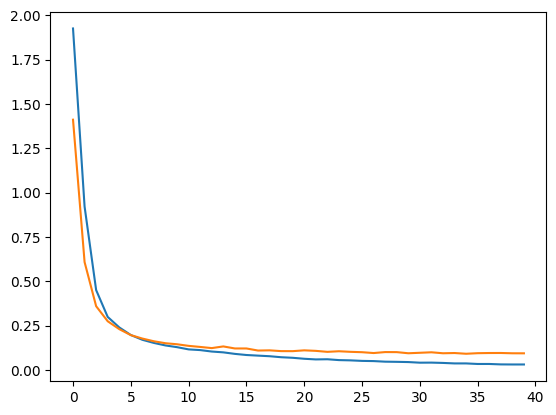

In [11]:
plt.plot(train_losses)
plt.plot(val_losses)

In [9]:
# Refactoring後の学習ループ
# early_stopping=None にすると、early stoppingせず100回学習ループを回す
num_in = 64
num_hidden = 30
num_out = 10
model = MLP(num_in, num_hidden, num_out)
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr=learning_rate)
num_epoch = 100
learn(model, train_loader, val_loader, opt, loss_func=F.cross_entropy, num_epoch=num_epoch, early_stopping=None)

epoch: 0: train error: 1.86846145523919, validation error: 1.2918465435504913, validation accuracy: 0.7604166666666666
epoch: 1: train error: 0.8670308709144592, validation error: 0.5655098358790079, validation accuracy: 0.890625
epoch: 2: train error: 0.437890664074156, validation error: 0.36555234094460803, validation accuracy: 0.890625
epoch: 3: train error: 0.301716262433264, validation error: 0.27972996421158314, validation accuracy: 0.9270833333333334
epoch: 4: train error: 0.23753240075376297, validation error: 0.2252084438999494, validation accuracy: 0.9401041666666666
epoch: 5: train error: 0.1984920947915978, validation error: 0.19589821932216486, validation accuracy: 0.9375
epoch: 6: train error: 0.17775078465541203, validation error: 0.18170556363960108, validation accuracy: 0.953125
epoch: 7: train error: 0.15561074250274234, validation error: 0.1651856228709221, validation accuracy: 0.9453125
epoch: 8: train error: 0.14088542759418488, validation error: 0.1484255318840344

([1.86846145523919,
  0.8670308709144592,
  0.437890664074156,
  0.301716262433264,
  0.23753240075376297,
  0.1984920947915978,
  0.17775078465541203,
  0.15561074250274234,
  0.14088542759418488,
  0.12765938548578157,
  0.11770472493436601,
  0.1108223574442996,
  0.10199616013301743,
  0.0981691068659226,
  0.09337756145331595,
  0.08751141300631894,
  0.08527351220448812,
  0.08064692525400055,
  0.07559788198106819,
  0.06921488977968693,
  0.06806760496563381,
  0.06542237928758064,
  0.06239945669141081,
  0.06297069845928085,
  0.059239507880475786,
  0.055557227600365876,
  0.05448735023124351,
  0.051739238533708785,
  0.050348256093760334,
  0.04779590860837036,
  0.046431589002410574,
  0.04375633341777656,
  0.04335437549485101,
  0.0413533840328455,
  0.04036232121288776,
  0.03954756963584158,
  0.03782269079238176,
  0.037442554854270484,
  0.03541679496152533,
  0.03422635021722979,
  0.03186399551729361,
  0.03153090291760034,
  0.03102111884703239,
  0.0298091664289

## モデルオブジェクトの保存とロード

- torch.save(): モデルを指定したパスに保存する
    - obj引数: 指定するモデルオブジェクト
    - ｆ引数: 保存するモデルのファイル名やパス
- torch.load(): したいしたパスからモデルをロードする
    - f引数: ロードするモデルのファイル名やパス
- 拡張子に'.pth'を使う習慣がある
- 保存後にコードを変更した場合や、異なる環境でロードした際に予期しない問題が起こる可能性があることに注意

In [13]:
# 下記のモデルを保存する
model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)

In [15]:
# モデルの保存
torch.save(model, 'sample_model.pth')

In [16]:
# モデルのロード
loaded_model = torch.load('sample_model.pth')
loaded_model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)

## モデルのパラメータの保存とロード

- 一般的に、オブジェクトの保存/ロードよりも推奨される
- .state_dict()でモデルのパラメータの情報のみを取り出す
- パラメータのみ切り出して保存することで、パラメータに関連するコード以外が変更されてもロードし使用することができる
- Optimizerについて同様にパラメータを保存することができる

In [20]:
params = model.state_dict()
params

OrderedDict([('l1.weight',
              tensor([[-0.1965, -0.0512,  0.2085,  ..., -0.4177, -0.3376, -0.2459],
                      [ 0.0272, -0.0209, -0.0410,  ...,  0.1517, -0.0434,  0.1746],
                      [ 0.0386, -0.1325, -0.2171,  ...,  0.0231,  0.0510, -0.0562],
                      ...,
                      [-0.0632, -0.0214, -0.1154,  ...,  0.4278,  0.1264,  0.0017],
                      [-0.0072, -0.1656,  0.0464,  ..., -0.2474, -0.3255, -0.0025],
                      [-0.0829, -0.0964, -0.2186,  ...,  0.0592, -0.0247,  0.0830]])),
             ('l1.bias',
              tensor([-0.0516,  0.1185,  0.1303,  0.1745, -0.0989,  0.0873, -0.0234,  0.0137,
                      -0.0151, -0.0329,  0.0424,  0.0775,  0.1056,  0.0138, -0.0693, -0.0518,
                       0.0917, -0.0286,  0.0364, -0.0893,  0.0873, -0.0806, -0.0507,  0.1187,
                       0.0695,  0.0540,  0.2147, -0.0672,  0.0184,  0.1336])),
             ('l2.weight',
              tensor([[ 8.

In [21]:
# 別のモデルを作成しparamsを呼び出す
another_model = MLP(64, 30, 10)
another_model.load_state_dict(params)

<All keys matched successfully>

In [23]:
list(another_model.parameters())

[Parameter containing:
 tensor([[-0.1965, -0.0512,  0.2085,  ..., -0.4177, -0.3376, -0.2459],
         [ 0.0272, -0.0209, -0.0410,  ...,  0.1517, -0.0434,  0.1746],
         [ 0.0386, -0.1325, -0.2171,  ...,  0.0231,  0.0510, -0.0562],
         ...,
         [-0.0632, -0.0214, -0.1154,  ...,  0.4278,  0.1264,  0.0017],
         [-0.0072, -0.1656,  0.0464,  ..., -0.2474, -0.3255, -0.0025],
         [-0.0829, -0.0964, -0.2186,  ...,  0.0592, -0.0247,  0.0830]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0516,  0.1185,  0.1303,  0.1745, -0.0989,  0.0873, -0.0234,  0.0137,
         -0.0151, -0.0329,  0.0424,  0.0775,  0.1056,  0.0138, -0.0693, -0.0518,
          0.0917, -0.0286,  0.0364, -0.0893,  0.0873, -0.0806, -0.0507,  0.1187,
          0.0695,  0.0540,  0.2147, -0.0672,  0.0184,  0.1336],
        requires_grad=True),
 Parameter containing:
 tensor([[ 8.6357e-01, -1.9148e-01, -7.0937e-01,  4.4161e-01,  4.8167e-02,
          -2.5190e-02, -2.1823e-01,  2.0353e-01, -

In [24]:
# modelとanother_modelの比較
another_model.l1.weight

Parameter containing:
tensor([[-0.1965, -0.0512,  0.2085,  ..., -0.4177, -0.3376, -0.2459],
        [ 0.0272, -0.0209, -0.0410,  ...,  0.1517, -0.0434,  0.1746],
        [ 0.0386, -0.1325, -0.2171,  ...,  0.0231,  0.0510, -0.0562],
        ...,
        [-0.0632, -0.0214, -0.1154,  ...,  0.4278,  0.1264,  0.0017],
        [-0.0072, -0.1656,  0.0464,  ..., -0.2474, -0.3255, -0.0025],
        [-0.0829, -0.0964, -0.2186,  ...,  0.0592, -0.0247,  0.0830]],
       requires_grad=True)

In [25]:
model.l1.weight

Parameter containing:
tensor([[-0.1965, -0.0512,  0.2085,  ..., -0.4177, -0.3376, -0.2459],
        [ 0.0272, -0.0209, -0.0410,  ...,  0.1517, -0.0434,  0.1746],
        [ 0.0386, -0.1325, -0.2171,  ...,  0.0231,  0.0510, -0.0562],
        ...,
        [-0.0632, -0.0214, -0.1154,  ...,  0.4278,  0.1264,  0.0017],
        [-0.0072, -0.1656,  0.0464,  ..., -0.2474, -0.3255, -0.0025],
        [-0.0829, -0.0964, -0.2186,  ...,  0.0592, -0.0247,  0.0830]],
       requires_grad=True)

In [29]:
# モデルのパラメータの保存
torch.save(model.state_dict(), 'sample_model_dict.pth')

In [30]:
# モデルのパラメータのロード
another_model.load_state_dict(torch.load('sample_model_dict.pth'))

<All keys matched successfully>

## 学習ループ中にモデルを保存する

In [36]:
# =============自作学習ループ関数=============
def learn(model, train_loader, val_loader, opt, loss_func, num_epoch, early_stopping=None, save_path=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')  # 1回目のval_lossを無限大とする
    no_improve = 0 # early stoppingのカウント用変数
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        
        for train_batch, data in enumerate(train_loader):
            
            X, y = data
            
            # mini batch作成 -> 削除
    
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds = model.forward(X) 
            loss = loss_func(preds, y)
            running_loss += loss.item()
            # backward
            loss.backward()
            opt.step()
            
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                
                preds_val = model(X_val)  
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0] 
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        # early ｓｔｏｐｐｉｎｇ
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            # モデルの保存
            if save_path is not None:
                state = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                    'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stoping early')
            break

    return train_losses, val_losses, val_accuracies

In [38]:
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5, save_path='checkpoint')

epoch: 0: train error: 1.9023839049869113, validation error: 1.342312604188919, validation accuracy: 0.84375
epoch: 1: train error: 0.9147914926211039, validation error: 0.5974241395791372, validation accuracy: 0.8802083333333334
epoch: 2: train error: 0.46239323251777226, validation error: 0.3844735150535901, validation accuracy: 0.9114583333333334
epoch: 3: train error: 0.3152361283699671, validation error: 0.2801151362558206, validation accuracy: 0.9401041666666666
epoch: 4: train error: 0.24528408249219258, validation error: 0.23144044975439707, validation accuracy: 0.9296875
epoch: 5: train error: 0.2006888962454266, validation error: 0.21848738193511963, validation accuracy: 0.9375
epoch: 6: train error: 0.1760530422959063, validation error: 0.19482566912968954, validation accuracy: 0.9479166666666666
epoch: 7: train error: 0.1555503295527564, validation error: 0.1763042143235604, validation accuracy: 0.9505208333333334
epoch: 8: train error: 0.14372090167469448, validation error

In [42]:
# モデルのロード
state = torch.load('checkpoint')
model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

In [43]:
# Optimizerのロード
opt.load_state_dict(state['optimizer_state_dict'])